## Imports

In [1]:
import re
import os
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor, log_evaluation, early_stopping

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from sklearn.feature_extraction import text
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from nltk import sent_tokenize, word_tokenize
from itertools import chain
from nltk.util import ngrams
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import concurrent.futures
from collections import Counter
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re

2024-05-29 09:30:15.569666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 09:30:15.569836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 09:30:15.782566: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
encoder = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-10-h-128-a-2/2", trainable=False)

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/bert-en-uncased-l-10-h-128-a-2/2' to your Kaggle notebook...


## Global variables

In [3]:
TRAIN_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv"
OUTPUT_PATH = '/kaggle/working/'

# Model parameters:
# as this is a simple model we use small vocabulary size and truncate to 400 words
NUM_EPOCHS = 100
VOCABULARY_SIZE = 2000
EMBEDDING_DIM = 120
MAX_LENGTH = 400
TRUNCATION_TYPE = 'post'
PADDING_TYPE = 'pre'
OOV_TOKEN = '<OOV>'
TRAIN_SIZE = .75
PATIENCE = 2

In [45]:
# that are the 7 topics of the essays and the corresponding leading tf idf terms
venus=['venus']
mars=['mars','face','alien','aliens','landform','martian','mesa']
cars=['accidents','self','smart','cars','car','driverless','driveless','usage','sensors','drive','driver','transportation','vehicle','vehicles','driving']
electoral=['vote','electoral','president','electors', 'state', 'senator','collage','ellection']
technology=['happy','huang','muscles','mona','lisa','computer','software','technology','emotions','facial','emotion','student','students','kids','teachers','feeling','teacher','feel','expressions']
luke=['luke','cowboy', 'seagoing','seagoing','cowboys','program','animals']
pollution=['air','pollution','smog','emissions','environment','city','paris','cities']
topic_words = venus + mars + cars + electoral +technology + luke + pollution
topic_words

['venus',
 'mars',
 'face',
 'alien',
 'aliens',
 'landform',
 'martian',
 'mesa',
 'accidents',
 'self',
 'smart',
 'cars',
 'car',
 'driverless',
 'driveless',
 'usage',
 'sensors',
 'drive',
 'driver',
 'transportation',
 'vehicle',
 'vehicles',
 'driving',
 'vote',
 'electoral',
 'president',
 'electors',
 'state',
 'senator',
 'collage',
 'happy',
 'huang',
 'muscles',
 'mona',
 'lisa',
 'computer',
 'software',
 'technology',
 'emotions',
 'facial',
 'emotion',
 'student',
 'students',
 'kids',
 'teachers',
 'feeling',
 'teacher',
 'feel',
 'expressions',
 'luke',
 'cowboy',
 'seagoing',
 'seagoing',
 'cowboys',
 'program',
 'animals',
 'air',
 'pollution',
 'smog',
 'emissions',
 'environment',
 'city',
 'paris',
 'cities']

## Loading the data

In [7]:
df_train = pd.read_csv(TRAIN_DATA_PATH)

## Finding all words similar to known topic words

In [28]:
all_text = ' '.join(df_train['full_text'])
# Tokenize the text into words, convert to lowercase, and extract unique words
words = re.findall(r'\b\w+\b', all_text.lower())
word_counts = Counter(words)
# Filter words that occur at least three times
words_used_at_least_three_times = [word for word, count in word_counts.items() if count >= 3]
print(f'Words used at least three times: {len(words_used_at_least_three_times)}')
unique_words = set(words_used_at_least_three_times)
vocab = list(unique_words)
vocab = sorted(vocab, key=lambda word: word_counts[word], reverse=True)

Words used at least three times: 20156


In [37]:
def exclude_words(text, words):
    pattern = re.compile(r'\b(' + '|'.join(words) + r')\b', re.IGNORECASE)
    return pattern.sub("topic", text)

## TF IDF to label simple cases

In [36]:
vectorizer = TfidfVectorizer(    
    strip_accents='unicode',    
    min_df=0.05,
    max_df=0.95,
    sublinear_tf=True,
    stop_words='english'
)
# Fit all dataset into TfidfVector
tfid = vectorizer.fit_transform(df_train['full_text'])
# Get feature names (terms)
terms = vectorizer.get_feature_names_out()
tf_idf_numpy=np.argsort(-tfid.toarray())

In [37]:
#creating 3 columns with 3 most popular terms from tf idf for each text 
first_best_indices = tf_idf_numpy[:,0]
second_best_indices = tf_idf_numpy[:,1]
third_best_indices = tf_idf_numpy[:,2]
first_tfidf_terms = [terms[idx] for idx in first_best_indices]
second_tfidf_terms = [terms[idx] for idx in second_best_indices]
third_tfidf_terms = [terms[idx] for idx in third_best_indices]
for i, termino in enumerate([first_tfidf_terms, second_tfidf_terms, third_tfidf_terms], start=1):    
    # Save the top TF-IDF term in a new column
    df_train[f'top_tfidf_term{i}'] = termino
    
#I assign the topic based on the category 
def find_first_list(term):
    if term in venus:
        return 'venus'
    elif term in mars:
        return 'mars'
    elif term in cars:
        return 'cars'
    elif term in electoral:
        return 'electoral'
    elif term in technology:
        return 'technology'
    elif term in luke:
        return 'luke'
    elif term in pollution:
        return 'pollution'
    else:
        return None

# Apply the function to each row to find the corresponding list for the first top TF-IDF term found
df_train['topic'] = df_train.apply(lambda row: find_first_list(row['top_tfidf_term1']) 
                                                if find_first_list(row['top_tfidf_term1']) else (
                                                find_first_list(row['top_tfidf_term2']) 
                                                if find_first_list(row['top_tfidf_term2']) else (
                                                find_first_list(row['top_tfidf_term3']) 
                                                if find_first_list(row['top_tfidf_term3']) else 'other')), axis=1)

## Data preprocessing

In [63]:
# separating labbeled and not labbeled data
df=df_train[df_train['topic']!='other']
df_test=df_train[df_train['topic']=='other']

In [ ]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
# Select the columns with the features
df_data_x = df[['full_text']]
# Select the column with the label:
df_data_y = df['topic']

# Split the samples:
x_train, x_test, y_train, y_test = train_test_split(df_data_x,
                                                    df_data_y,
                                                    train_size=TRAIN_SIZE,
                                                    random_state=42)

# create tokenizer
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train['full_text'])  
train_sequences = tokenizer.texts_to_sequences(x_train['full_text'])

# padding / truncating
train_padded = pad_sequences(train_sequences,
                             maxlen=MAX_LENGTH,
                             padding=PADDING_TYPE,
                             truncating=TRUNCATION_TYPE)

validation_sequences = tokenizer.texts_to_sequences(x_test['full_text'])
validation_padded = pad_sequences(validation_sequences,
                                  maxlen=MAX_LENGTH,
                                  padding=PADDING_TYPE,
                                  truncating=TRUNCATION_TYPE)

# encoding
encoder = LabelEncoder()
encoder.fit(y_train)    
encoded_y_train = to_categorical(encoder.transform(y_train))
encoded_y_test = to_categorical(encoder.transform(y_test))
num_classes = len(np.unique(y_train))

## RNN to create the model to label all data

In [56]:
# model creation
model = tf.keras.Sequential([
tf.keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_DIM),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.LSTM(128, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(256, activation="relu"),
tf.keras.layers.Dense(128, activation="relu"),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(num_classes, activation="softmax")
]) 

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Build the model by providing the input shape
model.build(input_shape=(None, MAX_LENGTH))

# summary and callback
model.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

# training
history = model.fit(train_padded,
                    encoded_y_train,
                    epochs=NUM_EPOCHS,
                    validation_data=(validation_padded, encoded_y_test),
                    callbacks=[callback]
                    ) 

predictotron = model.predict(validation_padded) 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 400, 120)       │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 400, 120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 400, 128)       │       127,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,335 (1.78 MB)

 Trainable params: 467,335 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 310s 762ms/step - accuracy: 0.4468 - loss: 1.3187 - val_accuracy: 0.8791 - val_loss: 0.3083
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 311s 733ms/step - accuracy: 0.8895 - loss: 0.3163 - val_accuracy: 0.9040 - val_loss: 0.2392
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 289s 646ms/step - accuracy: 0.8923 - loss: 0.3414 - val_accuracy: 0.8438 - val_loss: 0.3295
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 266s 657ms/step - accuracy: 0.9036 - loss: 0.2912 - val_accuracy: 0.9251 - val_loss: 0.2122
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 259s 650ms/step - accuracy: 0.9027 - loss: 0.3078 - val_accuracy: 0.9371 - val_loss: 0.1937
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 261s 649ms/step - accuracy: 0.9453 - loss: 0.1710 - val_accuracy: 0.9423 - val_loss: 0.1508
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 299s 749ms/step - accuracy: 0.9187 - loss: 0.2466 - val_accuracy: 0.9047 - val_loss: 0.2604
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 330s 770ms/step - accuracy: 

## CNN to create the model to label all data

Although for text data RNN normally work better, in this case the vocabulary is more important then the structure of the text.
So CNN can be much more faster with similar or better results.

In [88]:
# model creation
model_cnn = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_DIM),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(512, 5, activation="relu"),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

model_cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Build the model by providing the input shape
model_cnn.build(input_shape=(None, MAX_LENGTH))

# summary and callback
model_cnn.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)

# training
history_cnn = model_cnn.fit(train_padded,
                    encoded_y_train,
                    epochs=NUM_EPOCHS,
                    validation_data=(validation_padded, encoded_y_test),
                    callbacks=[callback]
                    ) 

predictotron_cnn = model_cnn.predict(validation_padded) 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 400, 120)       │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 400, 120)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 396, 512)       │       307,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 712,839 (2.72 MB)

 Trainable params: 712,839 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 100s 259ms/step - accuracy: 0.6942 - loss: 0.8141 - val_accuracy: 0.9485 - val_loss: 0.1365
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 98s 259ms/step - accuracy: 0.9564 - loss: 0.1291 - val_accuracy: 0.9570 - val_loss: 0.1082
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 142s 259ms/step - accuracy: 0.9669 - loss: 0.0894 - val_accuracy: 0.9614 - val_loss: 0.1022
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 142s 259ms/step - accuracy: 0.9758 - loss: 0.0704 - val_accuracy: 0.9595 - val_loss: 0.1024
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.9826 - loss: 0.0483 - val_accuracy: 0.9600 - val_loss: 0.1093
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step


## Printing the results

In [89]:
def printing (chosen_history):
    model_history = pd.DataFrame(chosen_history.history)
    model_history['epoch'] = chosen_history.epoch

    fig, ax = plt.subplots(1, figsize=(8, 6))
    num_epochs = model_history.shape[0]

    ax.plot(np.arange(0, num_epochs), model_history["accuracy"], label="Training Acc.")
    ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], label="Validation Acc.")
    ax.legend()

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, figsize=(8, 6))
    num_epochs = model_history.shape[0]

    ax.plot(np.arange(0, num_epochs), model_history["loss"], label="Training loss")
    ax.plot(np.arange(0, num_epochs), model_history["val_loss"], label="Validation loss")
    ax.legend()

    plt.tight_layout()
    plt.show()

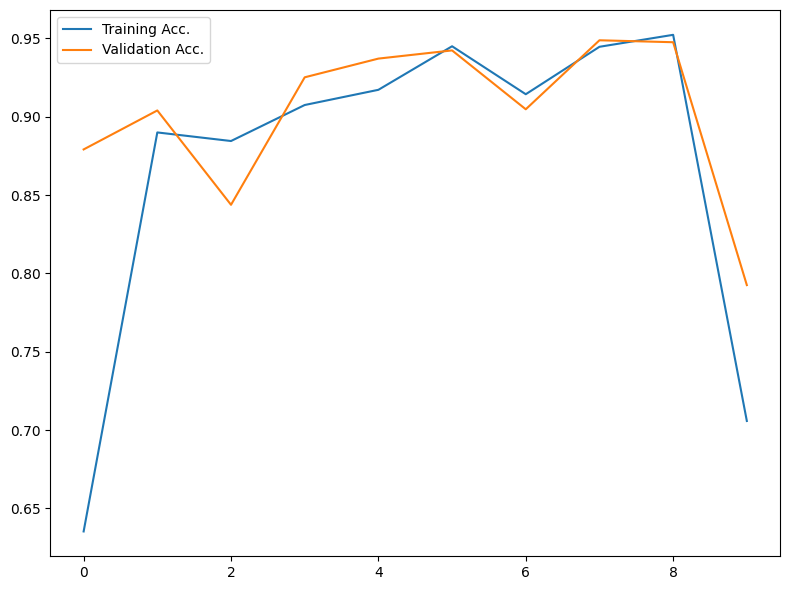

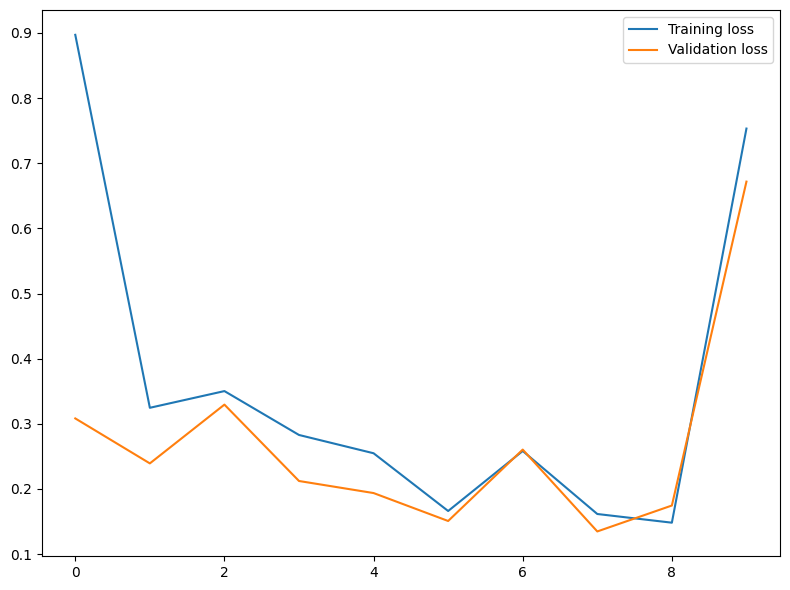

In [87]:
printing(history)

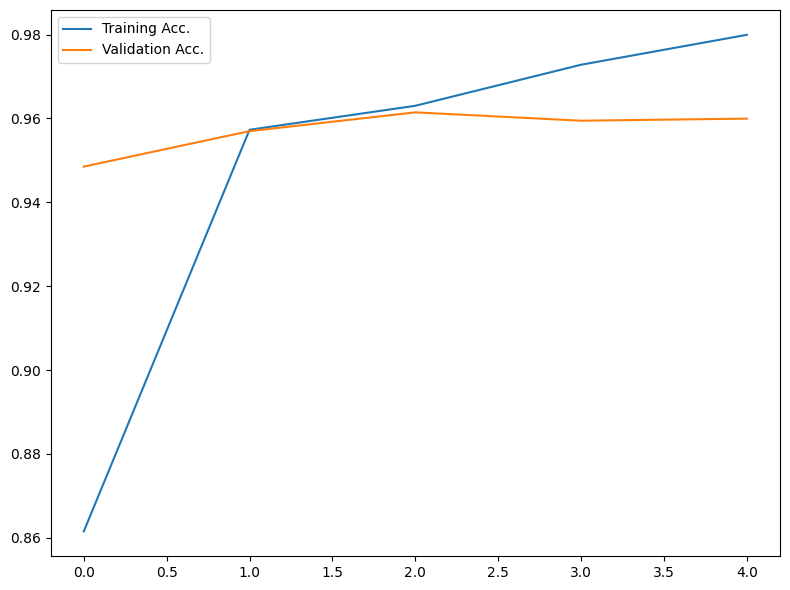

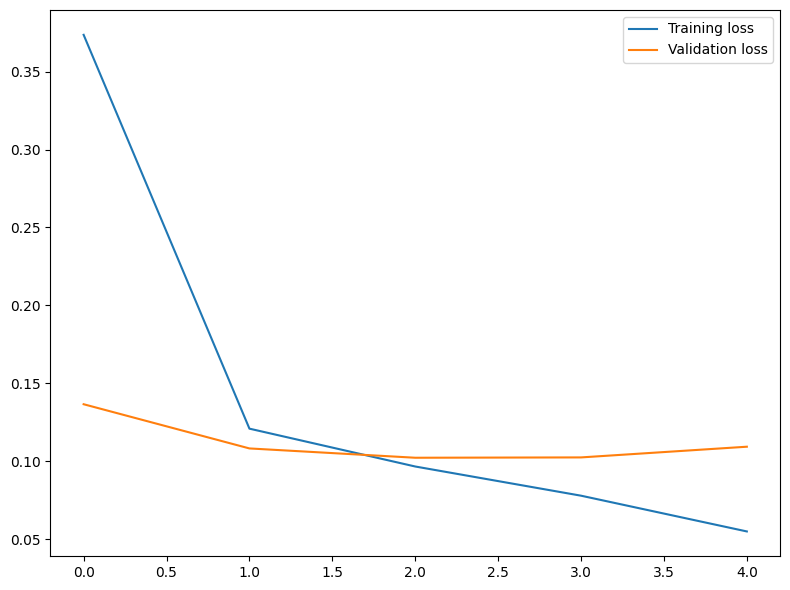

In [90]:
printing(history_cnn)

## Predictions 

In [91]:
def predict (df_to_predict, chosen_model):
    df_sequences = tokenizer.texts_to_sequences(df_to_predict['full_text'])
    df_sequences = pad_sequences(df_sequences,
                                     maxlen=MAX_LENGTH,
                                     padding=PADDING_TYPE,
                                     truncating=TRUNCATION_TYPE)

    prediction = chosen_model.predict(df_sequences)
    df_prob = pd.DataFrame(prediction)
    df_prob.columns = list(encoder.inverse_transform(range(0, prediction.shape[1])))
    #getting the most probable calue and its probabiliy
    max_probability_label = encoder.inverse_transform(np.argmax(prediction, 1))
    max_probability_value = np.max(prediction, 1)
    df_to_predict=df_to_predict.reset_index(drop=True)
    # joining with the df with text to check if it works fine
    df_probs_result = pd.concat([df_to_predict,                                 
                                     pd.DataFrame(max_probability_label, columns=['topic_pred']),
                                     pd.DataFrame(max_probability_value, columns=['highest_prob']),
                                     df_prob
                                     ], axis=1)
    return df_probs_result


In [85]:
# prediction for test and for whole df (RNN)
prediction_test=predict(df_test,model)
prediction_train=predict(df_train,model)
print(prediction_test.head(5))
print(prediction_train.head(5))

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step
541/541 ━━━━━━━━━━━━━━━━━━━━ 114s 211ms/step
  essay_id                                          full_text  score  \
0  004229b  I do not think that driverless cars are a good...      2   
1  00d027f  Imagine a system that can actually help you st...      3   
2  00fd564  The use of the Facial Action Coding System in ...      3   
3  0155be4  Everyone would like to have car that drives th...      3   
4  01711c3  Driveless cars can be a very great enhancement...      3   

  top_tfidf_term1 top_tfidf_term2 top_tfidf_term3  topic  topic_pred  \
0            safe       computers         walking  other        cars   
1          modify        learning       recognize  other  technology   
2          coding          action            test  other       venus   
3         control            turn           wants  other        cars   
4         society            save          google  other        cars   

   highest_prob      cars  electoral      luke  

In [72]:
# check the distribution of the df (RNN)
pivot=prediction_train.pivot_table(index='topic', columns='score', values='essay_id', aggfunc='count')
pivot


score,1,2,3,4,5,6
topic,,,,,,
cars,107.0,766.0,1488.0,1264.0,271.0,13.0
electoral,180.0,495.0,654.0,453.0,166.0,31.0
luke,139.0,651.0,556.0,154.0,12.0,NaN
mars,110.0,643.0,750.0,368.0,86.0,17.0
other,134.0,396.0,426.0,223.0,44.0,6.0
pollution,63.0,213.0,377.0,287.0,87.0,3.0
technology,178.0,743.0,1066.0,602.0,164.0,52.0
venus,341.0,816.0,963.0,575.0,140.0,34.0


In [92]:
# prediction for test and for whole df (CNN)
prediction_test_cnn=predict(df_test,model_cnn)
prediction_train_cnn=predict(df_train, model_cnn)
print(prediction_test_cnn.head(5))
print(prediction_train_cnn.head(5))

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
541/541 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step
  essay_id                                          full_text  score  \
0  004229b  I do not think that driverless cars are a good...      2   
1  00d027f  Imagine a system that can actually help you st...      3   
2  00fd564  The use of the Facial Action Coding System in ...      3   
3  0155be4  Everyone would like to have car that drives th...      3   
4  01711c3  Driveless cars can be a very great enhancement...      3   

  top_tfidf_term1 top_tfidf_term2 top_tfidf_term3  topic  topic_pred  \
0            safe       computers         walking  other        cars   
1          modify        learning       recognize  other  technology   
2          coding          action            test  other  technology   
3         control            turn           wants  other        cars   
4         society            save          google  other        cars   

   highest_prob      cars     electoral      luke  

In [93]:
# check the distribution of the df (CNN)
# comment: this shows better results as it covers all the 7 topics
pivot=prediction_train_cnn.pivot_table(index='topic_pred', columns='score', values='essay_id', aggfunc='count')
pivot

score,1,2,3,4,5,6
topic_pred,,,,,,
cars,143.0,884.0,1644.0,1376.0,283.0,15.0
electoral,188.0,514.0,673.0,466.0,170.0,32.0
luke,160.0,721.0,618.0,156.0,12.0,NaN
mars,127.0,689.0,789.0,390.0,91.0,17.0
pollution,73.0,230.0,393.0,297.0,97.0,3.0
technology,197.0,822.0,1155.0,648.0,175.0,55.0
venus,364.0,863.0,1008.0,593.0,142.0,34.0


In [95]:
# check the cases where tf idf label and model label are not the same to improve both methods in the future
# comment: it could be a good idea to retrain on the rows where tf idf label == model label and / or model prob for 1st option is high
prediction_train_cnn[(prediction_train_cnn['topic']!=prediction_train_cnn['topic_pred'])&(prediction_train_cnn['topic']!='other')]

,essay_id,full_text,score,top_tfidf_term1,top_tfidf_term2,top_tfidf_term3,topic,topic_pred,highest_prob,cars,electoral,luke,mars,pollution,technology,venus
15,0066c7c,My position on driveless cars are bad because ...,2,pollution,cars,alot,pollution,cars,0.996890,0.996890,0.000006,0.000120,0.000024,0.001897,0.001060,2.350514e-06
45,00e047b,A car is considered by many a nessecity for ev...,4,source,usage,city,cars,pollution,0.732417,0.267116,0.000069,0.000198,0.000016,0.732417,0.000142,4.267864e-05
80,019b862,The pursuit of the dangers includethings such ...,2,text,conditions,vehicle,cars,venus,0.435022,0.384330,0.001749,0.006525,0.007251,0.074225,0.090897,4.350225e-01
90,01bb061,There are many advantages of limiting car usag...,1,source,bogota,paris,pollution,cars,0.689247,0.689247,0.000119,0.000271,0.000096,0.309369,0.000708,1.908094e-04
120,0227e67,"Cars thery're every where, and people use cars...",4,cars,smog,air,cars,pollution,0.740059,0.257898,0.000338,0.001170,0.000043,0.740059,0.000311,1.821580e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16653,f559aba,Most likely im in a car every day of my life a...,4,money,air,stress,pollution,cars,0.996033,0.996033,0.000003,0.000046,0.000028,0.001865,0.002019,5.258841e-06
16889,f978b40,I think they should join the club. They are th...,2,join,happy,luke,technology,luke,0.566741,0.017196,0.000137,0.566741,0.000645,0.003521,0.411680,7.989792e-05
17113,fceec9d,"Many people believe they need a car to live, t...",2,happy,smog,percent,technology,pollution,0.578984,0.243844,0.002503,0.015606,0.002368,0.578984,0.151484,5.211665e-03
17241,fedc245,Gas has a horrible smell and its bad for the e...,2,stress,environment,cars,pollution,cars,0.983444,0.983444,0.000054,0.000479,0.000139,0.009122,0.006715,4.729478e-05
